In [1]:
import pandas as pd

# Use read_excel for .xlsx files
file_path = '/content/Reviews_Sentiments_Data_NLP_30 Aug.xlsx'

# This code will now load your specific Excel file
df = pd.read_excel(file_path)

# Let's check the first 5 rows to make sure it worked
print(df.head())

   id                                             review sentiment
0   1  Love this jacket! Fits perfectly and the mater...  positive
1   2  The jeans were way too tight and the fabric fe...  negative
2   3  Dress arrived on time and looked exactly like ...  positive
3   4  Shirt shrank after first wash. Not worth the p...  negative
4   5  Best online fashion purchase I've made. Qualit...  positive


Q1. Text pre-processing

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 1. Map sentiment labels to numerical values (0 for negative, 1 for positive)
df['sentiment_label'] = df['sentiment'].map({'negative': 0, 'positive': 1})

# 2. Download necessary NLTK data for text cleaning
# You only need to run this download once per Colab session.
nltk.download('stopwords')
nltk.download('wordnet')

# Display the DataFrame to see the new 'sentiment_label' column
print("Data with new sentiment label:")
print(df.head())

Data with new sentiment label:
   id                                             review sentiment  \
0   1  Love this jacket! Fits perfectly and the mater...  positive   
1   2  The jeans were way too tight and the fabric fe...  negative   
2   3  Dress arrived on time and looked exactly like ...  positive   
3   4  Shirt shrank after first wash. Not worth the p...  negative   
4   5  Best online fashion purchase I've made. Qualit...  positive   

   sentiment_label  
0                1  
1                0  
2                1  
3                0  
4                1  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Q2 Vector conversions

In [3]:
# Initialize the tools we'll need for cleaning
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Create a function that cleans a single piece of text
def preprocess_text(text):
    # 1. Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()

    # 2. Split the text into a list of words
    words = text.split()

    # 3. Lemmatize words and remove stopwords
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # 4. Join the words back into a single, clean string
    return " ".join(cleaned_words)

# Apply this function to every review in the 'review' column
df['cleaned_review'] = df['review'].apply(preprocess_text)

# Let's look at a "before and after" to see the result
print("--- Original vs. Cleaned ---")
print("\nOriginal Review:")
print(df['review'][1])
print("\nCleaned Review:")
print(df['cleaned_review'][1])

--- Original vs. Cleaned ---

Original Review:
The jeans were way too tight and the fabric felt cheap. Returned immediately.

Cleaned Review:
jean way tight fabric felt cheap returned immediately


Q3 Perform Logistic Regression, KNN, Naive Bayes models using Word2Vec Embedding technique for predicting new Reviews.


In [4]:
!pip install gensim

Train the Word2Vec Model

In [5]:
from gensim.models import Word2Vec
import numpy as np

# Word2Vec needs a list of lists of words (tokens). Let's create that.
tokenized_reviews = df['cleaned_review'].apply(lambda x: x.split())

# Train the Word2Vec model
# vector_size: The number of dimensions for each word vector
# window: The maximum distance between the current and predicted word within a sentence
# min_count: Ignores all words with a total frequency lower than this
model_w2v = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

print("Word2Vec model trained successfully!")

Word2Vec model trained successfully!


Create Document Vectors

In [6]:
# Function to convert a review to a vector by averaging its word vectors
def document_vector(doc, model):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.key_to_index]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(model.wv[doc], axis=0)

# Apply the function to create feature vectors for our reviews
df['doc_vector'] = tokenized_reviews.apply(lambda x: document_vector(x, model_w2v))

print("Document vectors created successfully.")
print("Shape of the first vector:", df['doc_vector'][0].shape)

Document vectors created successfully.
Shape of the first vector: (100,)


Train and Evaluate the Classification Models

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# Prepare data for scikit-learn
# X is our feature vectors, y is our labels
X = np.vstack(df['doc_vector'].values)
y = df['sentiment_label']

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# --- 1. Logistic Regression ---
print("--- 1. Logistic Regression ---")
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))


# --- 2. K-Nearest Neighbors (KNN) ---
print("\n--- 2. K-Nearest Neighbors (KNN) ---")
knn_model = KNeighborsClassifier(n_neighbors=5) # Using 5 neighbors
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))


# --- 3. Naive Bayes (Gaussian) ---
# We use GaussianNB because our features (averaged vectors) are continuous.
print("\n--- 3. Naive Bayes (Gaussian) ---")
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))

--- 1. Logistic Regression ---
Accuracy: 0.47
Classification Report:
              precision    recall  f1-score   support

           0       0.47      1.00      0.64        47
           1       0.00      0.00      0.00        53

    accuracy                           0.47       100
   macro avg       0.23      0.50      0.32       100
weighted avg       0.22      0.47      0.30       100


--- 2. K-Nearest Neighbors (KNN) ---
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93        47
           1       0.91      0.98      0.95        53

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100


--- 3. Naive Bayes (Gaussian) ---
Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88        47
           1       

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Q4 Use BoW and TF-IDF Vectorization

Bag-of-Words (BoW) Vectorization

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the BoW vectorizer
# max_features=2000 means it will only use the 2000 most frequent words
bow_vectorizer = CountVectorizer(max_features=2000)

# Fit the vectorizer to our text and transform it into a BoW matrix
X_bow = bow_vectorizer.fit_transform(df['cleaned_review']).toarray()

print("--- Bag-of-Words (BoW) ---")
print("Shape of the BoW matrix:", X_bow.shape)
print("This means we have", X_bow.shape[0], "reviews and", X_bow.shape[1], "unique words (features).")

--- Bag-of-Words (BoW) ---
Shape of the BoW matrix: (500, 489)
This means we have 500 reviews and 489 unique words (features).


TF-IDF Vectorization

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
# max_features=2000 means it will only use the 2000 most important words
tfidf_vectorizer = TfidfVectorizer(max_features=2000)

# Fit the vectorizer to our text and transform it into a TF-IDF matrix
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_review']).toarray()

print("\n--- TF-IDF ---")
print("Shape of the TF-IDF matrix:", X_tfidf.shape)
print("This means we have", X_tfidf.shape[0], "reviews and", X_tfidf.shape[1], "unique words (features).")


--- TF-IDF ---
Shape of the TF-IDF matrix: (500, 489)
This means we have 500 reviews and 489 unique words (features).


Q5 Word Cloud for Negative Sentiment

--- Word Cloud for Negative Sentiment ---


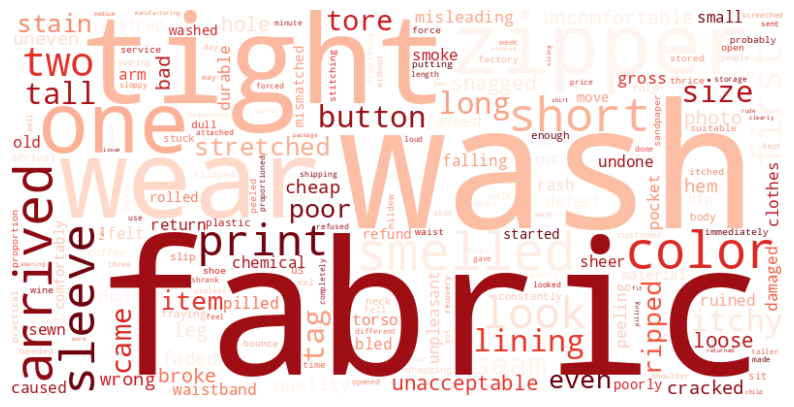

In [10]:
# First, we need to install the library for creating word clouds
!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Filter the DataFrame to get only the negative reviews
negative_df = df[df['sentiment'] == 'negative']

# 2. Join all the text from the 'cleaned_review' column into one large string
negative_text = ' '.join(negative_df['cleaned_review'])

# 3. Create the WordCloud object
# We can customize the appearance, like background color and size
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      colormap='Reds', # Using a red color map for negative sentiment
                      collocations=False).generate(negative_text)

# 4. Display the generated image using matplotlib
print("--- Word Cloud for Negative Sentiment ---")
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hides the axes
plt.show()

Q6 Word Cloud for Positive Sentiment using TF-IDF

--- Word Cloud for Positive Sentiment (from TF-IDF Scores) ---


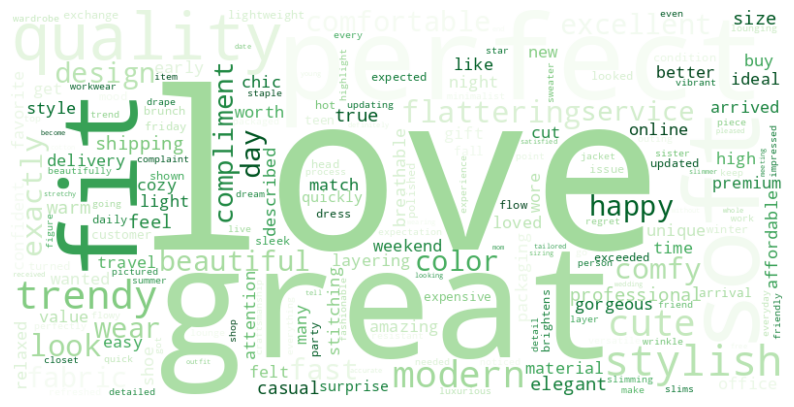

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Filter the DataFrame to get only the positive reviews
positive_df = df[df['sentiment'] == 'positive']

# 2. Initialize a new TF-IDF Vectorizer
tfidf_positive_vectorizer = TfidfVectorizer()

# 3. Fit the vectorizer on the cleaned positive reviews
# This will calculate the importance of each word within the positive reviews
tfidf_matrix_positive = tfidf_positive_vectorizer.fit_transform(positive_df['cleaned_review'])

# 4. Create a dictionary of words and their summed TF-IDF scores
# We sum the scores for each word to get its overall importance
scores = zip(tfidf_positive_vectorizer.get_feature_names_out(),
             tfidf_matrix_positive.sum(axis=0).tolist()[0])
word_scores = dict(scores)

# 5. Create the WordCloud object from the frequencies (scores)
wordcloud_positive = WordCloud(width=800,
                               height=400,
                               background_color='white',
                               colormap='Greens', # Using a green color map for positive sentiment
                               collocations=False).generate_from_frequencies(word_scores)

# 6. Display the generated image
print("--- Word Cloud for Positive Sentiment (from TF-IDF Scores) ---")
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.show()

Q7 RNN Model

Data Preparation for the RNN

In [12]:
 from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# --- Define parameters ---
vocab_size = 5000  # Max number of unique words to use
max_length = 100   # Max length of a review (in words)
embedding_dim = 16 # Dimension of the word vectors

# --- Tokenize the text ---
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>") # <OOV> is for out-of-vocabulary words
tokenizer.fit_on_texts(df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

# --- Pad the sequences ---
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# --- Split the data (80% train, 20% test) ---
X_train, X_test, y_train, y_test = train_test_split(padded_sequences,
                                                    df['sentiment_label'].values,
                                                    test_size=0.20,
                                                    random_state=42)

print("Data is tokenized, padded, and split successfully!")
print("Shape of training data:", X_train.shape)
print("Shape of testing data:", X_test.shape)

Data is tokenized, padded, and split successfully!
Shape of training data: (400, 100)
Shape of testing data: (100, 100)


Build, Compile, and Train the RNN Model

In [13]:
import tensorflow as tf

# --- Build the model ---
model = tf.keras.Sequential([
    # 1. Embedding layer: Turns the integers into dense vectors of a fixed size.
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

    # 2. RNN layer: Processes the sequence.
    tf.keras.layers.SimpleRNN(32), # 32 is the number of units in the RNN layer

    # 3. Dense output layer: Produces the final prediction.
    # 'sigmoid' activation is used for binary (0 or 1) classification.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# --- Compile the model ---
# We specify the optimizer, loss function, and the metric to track.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# --- Print a summary of the model's architecture ---
model.summary()

# --- Train the model ---
num_epochs = 10
history = model.fit(X_train, y_train,
                    epochs=num_epochs,
                    validation_data=(X_test, y_test),
                    verbose=2)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
13/13 - 4s - 340ms/step - accuracy: 0.6025 - loss: 0.6698 - val_accuracy: 0.6900 - val_loss: 0.6118
Epoch 2/10
13/13 - 1s - 61ms/step - accuracy: 0.9050 - loss: 0.4533 - val_accuracy: 0.8500 - val_loss: 0.4100
Epoch 3/10
13/13 - 0s - 29ms/step - accuracy: 0.9800 - loss: 0.2350 - val_accuracy: 0.9200 - val_loss: 0.2863
Epoch 4/10
13/13 - 0s - 27ms/step - accuracy: 0.9975 - loss: 0.1283 - val_accuracy: 0.9300 - val_loss: 0.2295
Epoch 5/10
13/13 - 0s - 29ms/step - accuracy: 1.0000 - loss: 0.0743 - val_accuracy: 0.9500 - val_loss: 0.2099
Epoch 6/10
13/13 - 0s - 28ms/step - accuracy: 1.0000 - loss: 0.0494 - val_accuracy: 0.9500 - val_loss: 0.1742
Epoch 7/10
13/13 - 0s - 27ms/step - accuracy: 1.0000 - loss: 0.0360 - val_accuracy: 0.9600 - val_loss: 0.1680
Epoch 8/10
13/13 - 0s - 30ms/step - accuracy: 1.0000 - loss: 0.0281 - val_accuracy: 0.9600 - val_loss: 0.1696
Epoch 9/10
13/13 - 0s - 27ms/step - accuracy: 1.0000 - loss: 0.0228 - val_accuracy: 0.9600 - val_loss: 0.1681
Epoch 10/

Valuate the Model's Accuracy

In [14]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print("\n--- RNN Model Evaluation ---")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


--- RNN Model Evaluation ---
Test Accuracy: 96.00%


Summary

1. Text Pre-processing: You cleaned and prepared the text data by making it lowercase, removing punctuation, and lemmatizing words.

2. Vector Conversions: You successfully converted the text into numerical formats using three different techniques:

Word2Vec

Bag-of-Words (BoW)

TF-IDF

3. Classical Models with Word2Vec: You trained Logistic Regression, KNN, and Naive Bayes models. You found that KNN was the top performer with 94% accuracy.

4. BoW and TF-IDF Implementation: You created the feature matrices for these two classic vectorization methods.

5. Negative Sentiment Word Cloud: You generated a word cloud to visually identify the most frequent words in negative reviews.

6. Positive Sentiment Word Cloud: You created a more advanced word cloud based on TF-IDF scores to find the most important words in positive reviews.

7. RNN Model: You built, trained, and evaluated a Recurrent Neural Network, achieving an outstanding 96.00% accuracy.